In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import SPCI_class as SPCI
from sklearn.model_selection import train_test_split

In [49]:

market_data = yf.download (tickers = "GOOGL", start = "2010-04-01", end = "2024-03-31", interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2010-04-01,14.298048,14.350601,14.152903,14.234234,14.234234,84023892,NaN,733863
2010-04-05,14.286787,14.386386,14.239239,14.289540,14.289540,75983940,0.003885,733867
2010-04-06,14.250751,14.286537,14.149149,14.219720,14.219720,82321596,-0.004886,733868
2010-04-07,14.196697,14.232983,14.060561,14.102603,14.102603,103136760,-0.008236,733869
2010-04-08,14.097097,14.260511,14.015265,14.201451,14.201451,77822100,0.007009,733870


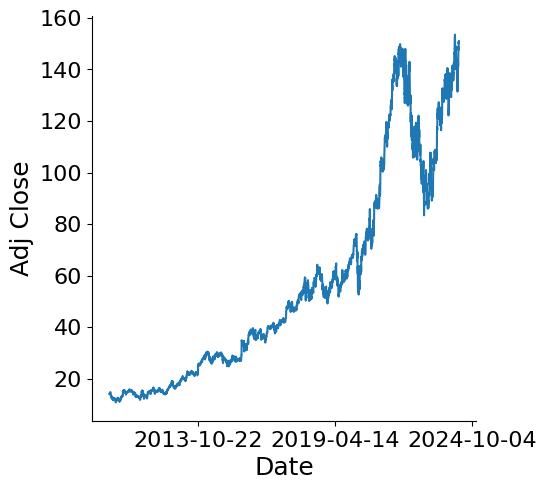

In [50]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [51]:
# Plot prediction intervals on test sample
def plot_ci(model, x_train, y_train, x_test, y_test, past_window = 30, alpha=0.1):

    SPCI_class_  = SPCI.SPCI_and_EnbPI(
        torch.from_numpy(x_train), 
        torch.from_numpy(x_test), 
        torch.from_numpy(y_train.reshape(-1)), 
        torch.from_numpy(y_test.reshape(-1)), 
        fit_func=model)
    stride = 1
    SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)

    use_SPCI = True
    smallT = not use_SPCI
    SPCI_class_.compute_PIs_Ensemble_online(alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI, quantile_regr=True, stride=stride)
    results = SPCI_class_.get_results(alpha, 'my_data', 1)

    Pred_ints = SPCI_class_.PIs_Ensemble
#     Y_est = SPCI_class_.Ensemble_pred_interval_centers
#     Y_predict = SPCI_class_.Y_predict.numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label=r'$Y$')
    plt.plot(model.predict(x_test), label=r'$\hat{Y}$')
    plt.fill_between(np.arange(len(y_test)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
    # plt.xlabel('Test time index')
    plt.ylabel('True $Y$ and prediction')
    # actual_cov = 100*results["coverage"].item()
    # actual_wid = results["width"].item()
    # plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

In [52]:
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2010-04-01,14.298048,14.350601,14.152903,14.234234,14.234234,84023892,NaN,733863
2010-04-05,14.286787,14.386386,14.239239,14.289540,14.289540,75983940,0.003885,733867
2010-04-06,14.250751,14.286537,14.149149,14.219720,14.219720,82321596,-0.004886,733868
2010-04-07,14.196697,14.232983,14.060561,14.102603,14.102603,103136760,-0.008236,733869
2010-04-08,14.097097,14.260511,14.015265,14.201451,14.201451,77822100,0.007009,733870


In [53]:
market_data['5_day_avg'] = market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['30_day_avg']= market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['year_avg'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['avg_ratio'] = market_data['5_day_avg']/market_data['year_avg']

market_data['5_day_std'] = market_data['Adj Close'].rolling(window=5).std().shift(1)
market_data['year_std'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['std_ratio'] = market_data['5_day_std']/market_data['year_std']
market_data.head(20)

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2010-04-01,14.298048,14.350601,14.152903,14.234234,14.234234,84023892,NaN,733863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-05,14.286787,14.386386,14.239239,14.289540,14.289540,75983940,0.003885,733867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-06,14.250751,14.286537,14.149149,14.219720,14.219720,82321596,-0.004886,733868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-07,14.196697,14.232983,14.060561,14.102603,14.102603,103136760,-0.008236,733869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-08,14.097097,14.260511,14.015265,14.201451,14.201451,77822100,0.007009,733870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-09,14.201451,14.233483,14.114114,14.169670,14.169670,82181736,-0.002238,733871,14.209510,14.209510,NaN,NaN,0.068217,NaN,NaN
2010-04-12,14.197948,14.364364,14.169670,14.332583,14.332583,94001904,0.011497,733874,14.196597,14.196597,NaN,NaN,0.068477,NaN,NaN
2010-04-13,14.327578,14.736737,14.292543,14.683934,14.683934,156335508,0.024514,733875,14.205206,14.205206,NaN,NaN,0.084024,NaN,NaN
2010-04-14,14.766266,14.823323,14.614865,14.739740,14.739740,135971892,0.003800,733876,14.298048,14.298048,NaN,NaN,0.231361,NaN,NaN


In [54]:
market_data = market_data.dropna()
print(market_data.shape)
x_train, x_test, y_train, y_test = train_test_split(market_data[['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std','year_std', 'std_ratio']], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(3157, 15)


((3127, 7), (30, 7), (3127, 1), (30, 1))

In [55]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.20362186431884766 secs.
Shape of slided residual lists is (30, 3127)
Width at test 0 is 3.837865471839905
Width at test 1 is 8.134542226791382
Width at test 2 is 8.925723612308502
Width at test 3 is 7.4543872475624084
Width at test 4 is 3.749961733818054
Width at test 5 is 5.32342004776001
Width at test 6 is 4.662413716316223
Width at test 7 is 8.80744368582964
Width at test 8 is 7.5544493198394775
Width at test 9 is 8.25950014591217
Width at test 10 is 5.822980046272278
Width at test 11 is 5.524730682373047
Width at test 12 is 8.632298946380615
Width at test 13 is 8.014614224433899
Width at test 14 is 8.633430153131485
Width at test 15 is 3.7469953298568726
Width at test 16 is 5.1790536642074585
Width at test 17 is 7.878400206565857
Width at test 18 is 7.727237273007631
Width at test 19 is 7.588800860568881
Width at test 20 is 8.129424095153809
Width at test 21 is 5.182637691497803
Width at test 22 is 8.623378664255142
Width a

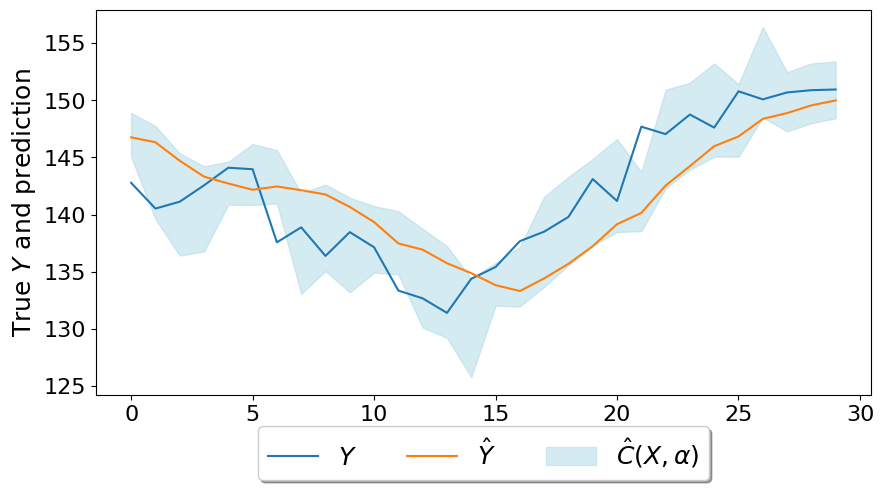

In [56]:
plot_ci(model, x_train, y_train, x_test, y_test, past_window=365, alpha=0.1)

Text(0, 0.5, 'True $Y$ and prediction')

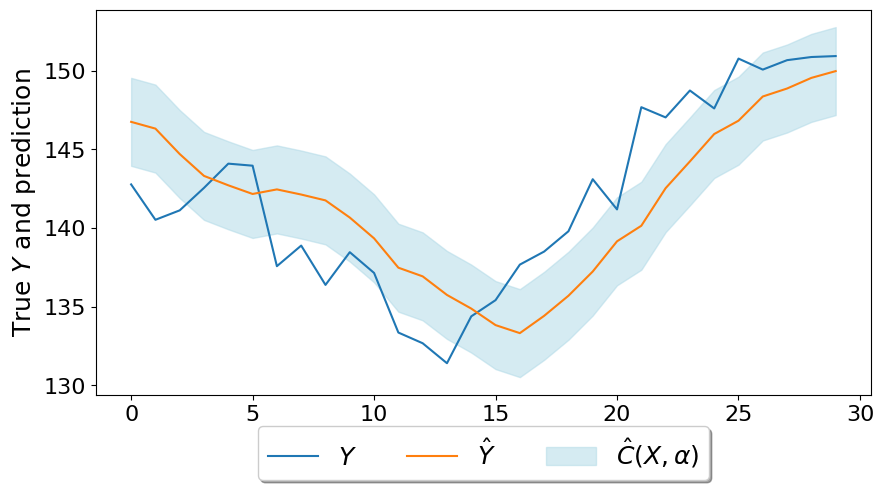

In [57]:
from scipy.stats import t

predictions = model.predict(x_test)

test_length = 30

alpha = 0.1

residuals = y_test - predictions
mse = np.mean(residuals**2)
se = np.sqrt(mse / (test_length - 8))

t_statistic = t.ppf(1 - alpha / 2, test_length - 8)

lower_bound = predictions - t_statistic * se
upper_bound = predictions + t_statistic * se

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test, label=r'$Y$')
plt.plot(predictions, label=r'$\hat{Y}$')
# plt.plot(predictions, color='blue', label='Predictions')
# plt.plot(y_test, color='black', label='Actuals')
plt.fill_between(np.arange(len(y_test)), lower_bound, upper_bound, alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
# plt.xlabel('Dates')
plt.ylabel('True $Y$ and prediction')
# plt.title('Linear Regression Predictions with 90% Confidence Interval')
# plt.legend()
# plt.grid(True)
# plt.show()
